<xarray.Dataset> Size: 430MB
Dimensions:                (time: 1827, latitude: 60, longitude: 140)
Coordinates:
  * time                   (time) datetime64[ns] 15kB 2010-01-01 ... 2015-01-01
  * latitude               (latitude) float32 240B 48.03 48.08 ... 50.93 50.98
  * longitude              (longitude) float32 560B -4.975 -4.925 ... 1.975
Data variables:
    analysed_sst           (time, latitude, longitude) float32 61MB ...
    analysed_st            (time, latitude, longitude) float32 61MB ...
    analysis_error_sst     (time, latitude, longitude) float32 61MB ...
    analysis_error_st      (time, latitude, longitude) float32 61MB ...
    mask                   (time, latitude, longitude) float32 61MB ...
    sea_ice_fraction       (time, latitude, longitude) float32 61MB ...
    sea_ice_fraction_flag  (time, latitude, longitude) float32 61MB ...
Attributes:
    Conventions:       CF-1.11
    title:             Global Sea and Ice Surface Temperature, L4, 5km daily ...
    insti

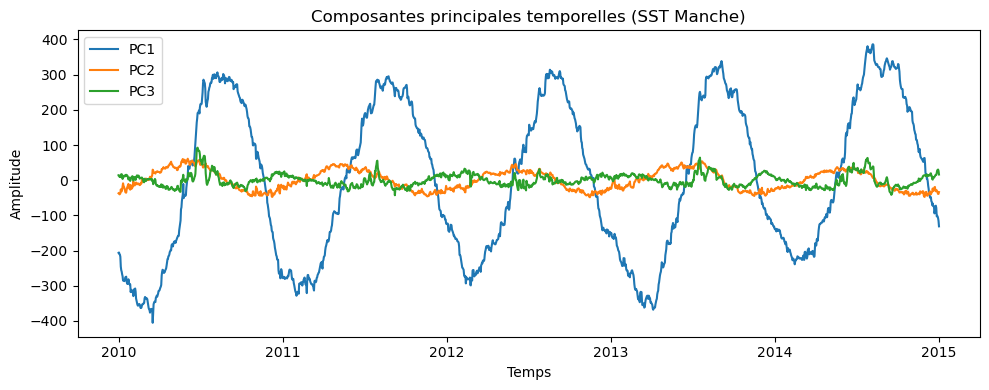

Erreur quadratique moyenne de reconstruction : 0.048357785
État dynamique x(t) : (1827, 3)


FileNotFoundError: [Errno 2] No such file or directory: '../data/processed/etat_dynamique_PCA.npy'

In [2]:
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

# chargement via NedCDF (xarray lib)

ds = xr.open_dataset("data/raw/C3S-GLO-SST-L4-REP-OBS-SST_1767389520200_part1.nc")
print(ds)

sst = ds["analysed_sst"]

if sst.attrs.get("units", "").lower() in ["kelvin", "k"]: # conversion degré
    sst = sst - 273.15
    sst.attrs["units"] = "degC"

print("Période :", sst.time.values[0], "→", sst.time.values[-1])
print("Latitude :", float(sst.latitude.min()), "→", float(sst.latitude.max()))
print("Longitude :", float(sst.longitude.min()), "→", float(sst.longitude.max()))

n_lat = sst.sizes["latitude"]
n_lon = sst.sizes["longitude"]
print("Points spatiaux par jour :", n_lat * n_lon)

sst_flat = sst.stack(space=("latitude", "longitude")) # applatissement de l'espace

sst_anom = sst_flat - sst_flat.mean(dim="time") # On "retire" la moyenne de l'aplatissement

X = sst_anom.values  # shape = (temps, espace)

X = np.nan_to_num(X) # NaN management

# PCA

n_components = 3
pca = PCA(n_components=n_components)

X_pca = pca.fit_transform(X)

print("Variance expliquée par composante :")
for i, v in enumerate(pca.explained_variance_ratio_):
    print(f"  PC{i+1}: {100*v:.2f} %")

print("Variance cumulée :", 100 * pca.explained_variance_ratio_.sum(), "%")

time = sst.time.values

plt.figure(figsize=(10, 4))
for i in range(n_components):
    plt.plot(time, X_pca[:, i], label=f"PC{i+1}")

plt.legend()
plt.title("Composantes principales temporelles (SST Manche)")
plt.xlabel("Temps")
plt.ylabel("Amplitude")
plt.tight_layout()
plt.show()

X_rec = pca.inverse_transform(X_pca)
reconstruction_error = np.mean((X - X_rec)**2)

print("Erreur quadratique moyenne de reconstruction :", reconstruction_error)

# état réduit x(t)
x_t = X_pca  # shape = (temps, n_components)

print("État dynamique x(t) :", x_t.shape)

np.save("../data/processed/etat_dynamique_PCA.npy", x_t)

